In [2]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.utils import shuffle

In [3]:
DATA_DIR = "../data"

TRAIN_DIR = os.path.join(DATA_DIR, "train")
VAL_DIR = os.path.join(DATA_DIR, "val")
TEST_DIR = os.path.join(DATA_DIR, "test")


In [4]:
def audio_to_melspectrogram(file_path):
    y, sr = librosa.load(file_path)  # load full audio, any duration
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    S_dB = librosa.power_to_db(S, ref=np.max)

    # Resize to 128x128 (model input)
    S_resized = tf.image.resize(S_dB[..., np.newaxis], (128, 128))
    return S_resized.numpy()


In [5]:
def load_dataset(folder):
    x_data = []
    y_data = []

    highlight_dir = os.path.join(folder, "highlights")
    non_dir = os.path.join(folder, "non_highlights")

    for file in os.listdir(highlight_dir):
        fp = os.path.join(highlight_dir, file)
        x_data.append(audio_to_melspectrogram(fp))
        y_data.append(1)

    for file in os.listdir(non_dir):
        fp = os.path.join(non_dir, file)
        x_data.append(audio_to_melspectrogram(fp))
        y_data.append(0)

    x_data = np.array(x_data)
    y_data = np.array(y_data)

    return shuffle(x_data, y_data, random_state=42)


In [6]:
x_train, y_train = load_dataset(TRAIN_DIR)
x_val, y_val = load_dataset(VAL_DIR)
x_test, y_test = load_dataset(TEST_DIR)

x_train.shape, x_val.shape, x_test.shape

print("finished loading datasets")


finished loading datasets


In [7]:
model = models.Sequential([
    layers.Input(shape=(128, 128, 1)),

    layers.Conv2D(16, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 16)        │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         802,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 826,241 (3.15 MB)

 Trainable params: 826,241 (3.15 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=15,
    batch_size=8
)

Epoch 1/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.5377 - loss: 9.8174 - val_accuracy: 0.6087 - val_loss: 0.8980
Epoch 2/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.5849 - loss: 0.7100 - val_accuracy: 0.6522 - val_loss: 0.6727
Epoch 3/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.6887 - loss: 0.6744 - val_accuracy: 0.6087 - val_loss: 0.6909
Epoch 4/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.7264 - loss: 0.6852 - val_accuracy: 0.7826 - val_loss: 0.6766
Epoch 5/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.7453 - loss: 0.6771 - val_accuracy: 0.5652 - val_loss: 0.6736
Epoch 6/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.6981 - loss: 0.6522 - val_accuracy: 0.9130 - val_loss: 0.6361
Epoch 7/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.6415 - loss: 0.6791 - val_accuracy: 0.6087 - val_loss: 0.6843
Epoch 8/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5283 - loss: 0.7349 - val_accuracy: 0.6087 - v

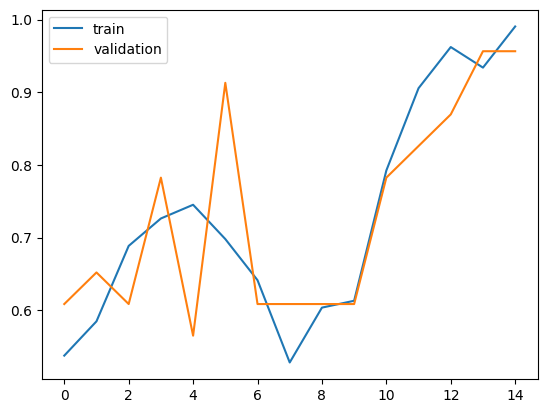

In [9]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(["train", "validation"])
plt.show()

In [10]:
loss, acc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {acc*100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.8571 - loss: 0.3574
Test Accuracy: 85.71%


In [12]:
model.save("../streamlit_app/ufc_highlight_model.keras")
print("model saved")

model saved
